In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm as tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix

torch.set_printoptions(linewidth=120)

### model

In [41]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120) #fc ~ fully connected ~ dense ~ linear
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) #these 10 are the output categories!

    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        
        return t

### data

In [42]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=100
    ,shuffle=True
)

In [43]:
network = Network()
network.load_state_dict(torch.load('./mynet.pth'))
network.eval()

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [44]:
img,label = next(iter(train_set))

In [45]:
F.softmax(network(img.unsqueeze(0)),dim=1).argmax().item()

9

In [46]:
label

9

predictions one by one

In [47]:
train_iter = iter(train_set)

for i in range(50):
    image,label = next(train_iter)
    print(F.softmax(network(image.unsqueeze(0)),dim=1).argmax().item(),end='')
    print(" - ", end='')
    print(label)

9 - 9
0 - 0
0 - 0
3 - 3
0 - 0
2 - 2
7 - 7
4 - 2
5 - 5
5 - 5
0 - 0
9 - 9
5 - 5
5 - 5
7 - 7
9 - 9
1 - 1
0 - 0
6 - 6
4 - 4
3 - 3
1 - 1
4 - 4
8 - 8
4 - 4
3 - 3
0 - 0
2 - 2
4 - 4
4 - 4
5 - 5
3 - 3
6 - 6
6 - 6
0 - 0
8 - 8
9 - 5
2 - 2
1 - 1
6 - 6
6 - 6
7 - 7
9 - 9
5 - 5
9 - 9
2 - 2
7 - 7
3 - 3
0 - 0
3 - 3


predictions of whole set

In [87]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [95]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [100]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)
    
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 53839
accuracy: 0.8973166666666667


In [99]:
def other_test(model,loader):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        
    print('Test Accuracy of the model on the', len(loader) * loader.batch_size, 'test images: %.2f' % accuracy)

### Confusion matrix

In [101]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [102]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [103]:
stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [104]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [105]:
stacked.shape

torch.Size([60000, 2])

In [106]:
stacked[0].tolist()

[9, 9]

## Custom CONFMAT

In [121]:
cmt = torch.zeros(10,10, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [122]:
for p in stacked:
    targ, pred = p.tolist()
    cmt[targ, pred] = cmt[targ, pred] + 1
cmt

tensor([[4965,   10,   52,   88,   11,    3,  827,    0,   44,    0],
        [   3, 5915,    3,   48,   11,    0,   16,    0,    4,    0],
        [  29,    5, 4824,   13,  556,    1,  551,    0,   21,    0],
        [ 130,   81,   20, 5168,  326,    0,  248,    0,   27,    0],
        [   5,    6,  316,   69, 5091,    0,  503,    0,   10,    0],
        [   0,    0,    1,    2,    0, 5764,    0,  137,   15,   81],
        [ 612,    4,  298,   74,  349,    1, 4629,    0,   33,    0],
        [   0,    0,    0,    1,    0,   38,    0, 5792,    6,  163],
        [   4,    6,   12,    7,   22,   11,   47,    3, 5886,    2],
        [   0,    0,    0,    0,    0,   12,    1,  177,    5, 5805]])

## IN-BUILT CONFMAT and plotting

Confusion matrix, without normalization
[[4965   10   52   88   11    3  827    0   44    0]
 [   3 5915    3   48   11    0   16    0    4    0]
 [  29    5 4824   13  556    1  551    0   21    0]
 [ 130   81   20 5168  326    0  248    0   27    0]
 [   5    6  316   69 5091    0  503    0   10    0]
 [   0    0    1    2    0 5764    0  137   15   81]
 [ 612    4  298   74  349    1 4629    0   33    0]
 [   0    0    0    1    0   38    0 5792    6  163]
 [   4    6   12    7   22   11   47    3 5886    2]
 [   0    0    0    0    0   12    1  177    5 5805]]


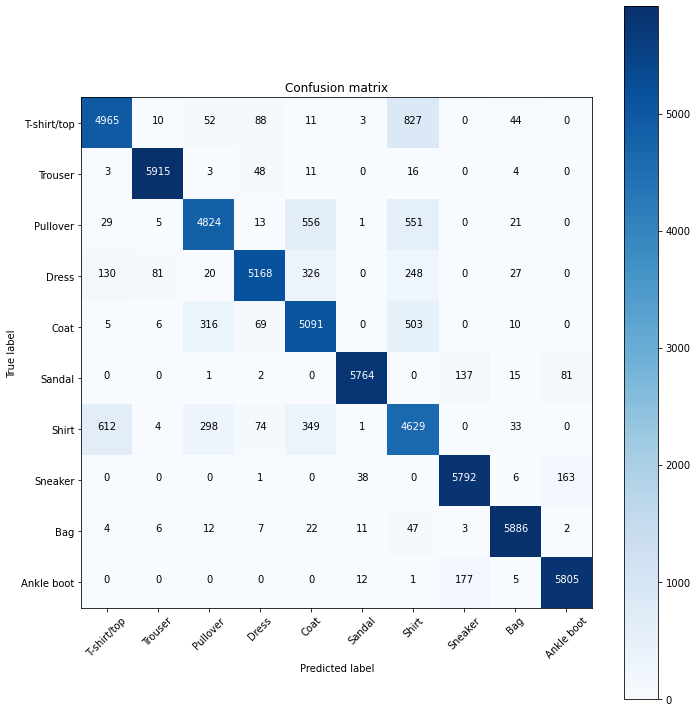

In [123]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, train_set.classes)